# Оптимизация выполнения кода, векторизация, Numba

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Макрушин С.В. "Оптимизация выполнения кода, векторизация, Numba"
* IPython Cookbook, Second Edition (2018), глава 4
* https://ipython-books.github.io/43-profiling-your-code-line-by-line-with-line_profiler/
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html
* https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

In [95]:
path = 'C://Users//icom1//OneDrive - icom//Рабочий стол//'

## Задачи для совместного разбора

In [96]:
import numpy as np
from numba import njit

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [97]:
A = np.random.randint(0, 1_000, size=(1_000_000))
A

array([887, 868, 813, ..., 143, 689,  51])

In [98]:
def f1(A):
    acc, cnt = 0, 0
    for i in range(len(A)):
        bi = A[i] + 100
        acc += bi
        cnt += 1
    return acc / cnt

In [99]:
#%% + название команды - на уровне всей ячейки
#% + название команды - на уровне одной строчки

In [100]:
%%time
f1(A)

CPU times: total: 578 ms
Wall time: 594 ms


599.562051

In [101]:
%time f1(A)

CPU times: total: 594 ms
Wall time: 586 ms


599.562051

In [102]:
def f2(A):
    acc = 0
    for i in range(len(A)):
        acc += A[i]
    return acc / len(A) + 100

In [103]:
%time f2(A)

CPU times: total: 359 ms
Wall time: 356 ms


599.562051

In [104]:
%time np.mean(A + 100)

CPU times: total: 15.6 ms
Wall time: 10.8 ms


599.562051

In [105]:
%time A.mean() + 100

CPU times: total: 15.6 ms
Wall time: 7.99 ms


599.562051

In [106]:
from numba import njit

In [107]:
@njit
def f3(A):
    acc = 0
    for i in range(len(A)):
        acc += A[i]
    return acc / len(A) + 100

In [108]:
%time f3(A)

CPU times: total: 422 ms
Wall time: 473 ms


599.562051

In [109]:
%time f3(A)

CPU times: total: 0 ns
Wall time: 0 ns


599.562051

In [110]:
#%timeit - выполняет строку несколько раз

In [111]:
%timeit f3(A)

503 µs ± 101 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


2. Напишите функцию, которая возвращает сумму всех чисел от 0 до x-1. Примените функцию к каждому элементу массива.

In [112]:
def g(x):
    return sum(range(x))

In [113]:
g(10)

45

In [114]:
%%time
np.array([g(a) for a in A])

CPU times: total: 20 s
Wall time: 20.3 s


array([392941, 376278, 330078, ...,  10153, 237016,   1275])

In [115]:
g_v = np.vectorize(g)

In [116]:
%%time
g_v(A)

CPU times: total: 16.6 s
Wall time: 16.6 s


array([392941, 376278, 330078, ...,  10153, 237016,   1275])

In [117]:
%%time
g_v(A).mean()

CPU times: total: 16.6 s
Wall time: 17.2 s


166225.206399

In [118]:
import numba
numba.__version__

'0.56.3'

In [119]:
#передать входные и выходные параметры
#int32 - output
#(int32) - input
g_v2 = numba.vectorize(["int32(int32)"])(g)

In [120]:
%%time
g_v2(A)

CPU times: total: 141 ms
Wall time: 138 ms


array([392941, 376278, 330078, ...,  10153, 237016,   1275])

3. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [121]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [122]:
import pandas as pd
import string

N = 2_000_000
df = pd.DataFrame(np.random.randn(N, 4), columns=[f"col{i}" for i in range(4)])
df["key"] = np.random.choice(list(string.ascii_letters.lower()), N, replace=True)
df.head(2)

,col0,col1,col2,col3,key
0,-0.642490,0.371335,0.425582,0.517263,k
1,0.407833,1.373054,-0.433602,1.209295,b


In [123]:
#DO NOT RUN
def h1(df):
    mask = []
    for _, row in df.iterrows():
        mask.append(row['key'] in {'a','b','c','d','e'})
    return df[mask]

In [124]:
%%time
h1(df.head(10000))

CPU times: total: 812 ms
Wall time: 866 ms


,col0,col1,col2,col3,key
1,0.407833,1.373054,-0.433602,1.209295,b
8,0.964214,0.420306,1.776745,1.072314,d
14,0.194688,-0.482029,0.414440,2.192573,e
20,0.464036,1.579370,-2.192461,1.336951,a
21,-0.400577,-0.866273,-1.355920,0.491159,c
...,...,...,...,...,...
9968,-0.199157,0.373656,0.005258,1.203645,d
9971,-1.361667,2.001885,-0.786766,-0.965548,c
9976,-1.462371,-0.703680,-0.558808,1.723245,d
9982,-0.254148,-0.232789,0.267683,1.175219,e


In [125]:
%lprun -f h1 h1(df.head(10000))

In [126]:
%%time
df[df['key'].isin({'a','b','c','d','e'})]

CPU times: total: 219 ms
Wall time: 267 ms


,col0,col1,col2,col3,key
1,0.407833,1.373054,-0.433602,1.209295,b
8,0.964214,0.420306,1.776745,1.072314,d
14,0.194688,-0.482029,0.414440,2.192573,e
20,0.464036,1.579370,-2.192461,1.336951,a
21,-0.400577,-0.866273,-1.355920,0.491159,c
...,...,...,...,...,...
1999991,-1.304655,-0.625966,-0.415059,0.250985,e
1999993,0.501515,-1.634394,-0.494226,0.350186,d
1999994,0.777942,-0.275466,-3.124599,-0.164128,b
1999995,0.706938,-1.668001,0.553945,-1.080793,e


## Лабораторная работа 3

In [127]:
import numpy as np
import pandas as pd
from numba import jit, njit
import numba
from typing import Union

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

In [128]:
recipes = pd.read_csv(path+'recipes_sample.csv')
reviews = pd.read_csv(path+'reviews_sample.csv', index_col='Unnamed: 0')

In [129]:
recipes.dtypes

name               object
id                  int64
minutes             int64
contributor_id      int64
submitted          object
n_steps           float64
description        object
n_ingredients     float64
dtype: object

In [130]:
reviews.dtypes

user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

In [131]:
recipes['submitted'] = pd.to_datetime(recipes['submitted'])
reviews['date'] = pd.to_datetime(reviews['date'])
recipes['submitted'].dtypes, reviews['date'].dtypes

(dtype('<M8[ns]'), dtype('<M8[ns]'))

## Измерение времени выполнения кода

Назовем полным описанием рецепта строку, полученную путем конкатенации названия и описания рецепта через пробел. Удалите строки для рецептов, которые были добавлены не в 2010 году.

Реализуйте несколько вариантов функции подсчета средней длины полного описания рецепта для рецептов, добавленных в 2010 году.

In [132]:
recipes_2010 = recipes[recipes.submitted.dt.year == 2010]
reviews_2010 = reviews[reviews.date.dt.year == 2010]

recipes = recipes[recipes.submitted.dt.year != 2010]
reviews = reviews[reviews.date.dt.year != 2010]

In [133]:
recipes_2010.head(1)

,name,id,minutes,contributor_id,submitted,n_steps,description,n_ingredients
52,just peachy cobbler,437637,70,1085867,2010-09-17,10.0,all i can say is yummmmmm . . . a simple to ma...,10.0


In [134]:
reviews_2010.head(1)

,user_id,recipe_id,date,rating,review
115270,383346,328668,2010-12-21,5,This soup is so comforting. I used low-sodium...


In [135]:
recipes_2010['concat'] = recipes_2010.name + ' ' + recipes_2010.description

1\.1 С использованием метода `DataFrame.iterrows` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - нахождение полного описания рецепта осуществляется внутри цикла по `iterrows` для каждой строки по отдельности.

In [214]:
def get_mean_len_A(df: pd.DataFrame) -> float:
    length = 0
    counter = 0
    for _, row in df.iterrows():
        length += len(row['concat'])
        counter += 1
    return length/counter

In [215]:
%time get_mean_len_A(recipes_2010)

CPU times: total: 297 ms
Wall time: 292 ms


265.501300390117

1\.2. С использованием метода `DataFrame.apply` таблицы:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - вызываете метод apply у таблицы, в качестве аргумента передаете функцию, которая возвращает полное описание для каждой строки;
    
    - считаете среднюю длину описаний, вызвав соответствующий метод серии.

In [216]:
def get_mean_len_B(df: pd.DataFrame) -> float:
    foo = lambda col: len((col['name'] + ' ' + col['description']))
    mean_ = df.apply(foo, axis = 1)
    return sum(mean_)/len(mean_)

In [217]:
%time get_mean_len_B(recipes_2010)

CPU times: total: 93.8 ms
Wall time: 84.2 ms


265.501300390117

1\.3. С использованием векторизованных методов серий `pd.Series`:

    - функция принимает на вход таблицу, содержащую рецепты за 2010 год;
    
    - при помощи векторизированных операций получаете столбец с полным описанием;
    
    - при помощи векторизированных операций получаете длины полного описания;
    
    - при помощи векторизированных операций получаете среднюю длину полных описаний. 

In [218]:
def get_mean_len_C(df: pd.DataFrame) -> float:
    mean_ = df.name + ' ' + df.description
    return mean_.str.len().mean()

In [219]:
%time get_mean_len_C(recipes_2010)

CPU times: total: 15.6 ms
Wall time: 8.61 ms


265.501300390117

1.4 Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций при помощи магических команд `time` и `timeit`.

In [220]:
%time get_mean_len_A(recipes_2010)
print()
%time get_mean_len_B(recipes_2010)
print()
%time get_mean_len_C(recipes_2010)

CPU times: total: 281 ms
Wall time: 341 ms

CPU times: total: 125 ms
Wall time: 121 ms

CPU times: total: 0 ns
Wall time: 11.7 ms


265.501300390117

## Анализ пошагового выполнения кода 

Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. 

In [143]:
import re


def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        recipe_id, review = row["recipe_id"], row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)

    word_reviews_count = {}
    for _, row in df.dropna(subset=["review"]).iterrows():
        review = row["review"]
        words = re.sub("[^A-Za-z\s]", "", review).split(" ")
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

2.1 Найдите узкие места в коде, проанализировав код функции по шагам, используя профайлер. Сохраните результаты работы профайлера в отдельную текстовую ячейку. Выпишите (словами), что в имеющемся коде реализовано неоптимально. 

In [144]:
%lprun -f get_word_reviews_count get_word_reviews_count(reviews)

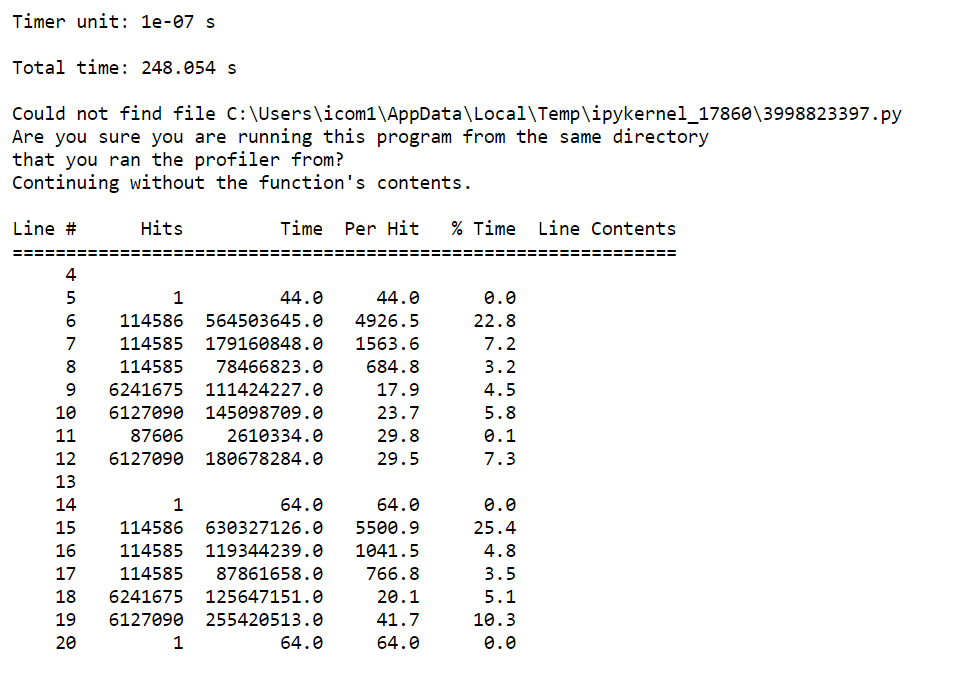

Очень много времени занимает итерирование по строкам в датафрейме, как в первый, так и во втором случае
---
Также цикл записи слов в словарь также занимает приблизительно 10% времени
---

2.2  Оптимизируйте функцию и добейтесь значительного (как минимум, в 5 раз) прироста в скорости выполнения. Для демонстрации результата измерьте скорость выполнения оригинальной функции и функции, написанной вами.

In [247]:
#Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово.
from collections import Counter
def get_word_reviews_count(df):
    results = Counter()
    df = df.dropna(subset=["review"])
    df = df.review.apply(lambda x: re.sub(r'[^A-Za-z\s]', '', x).split(" "))
    df.apply(lambda i: set(i)).apply(results.update)
    return results

In [248]:
%lprun -f get_word_reviews_count get_word_reviews_count(reviews)

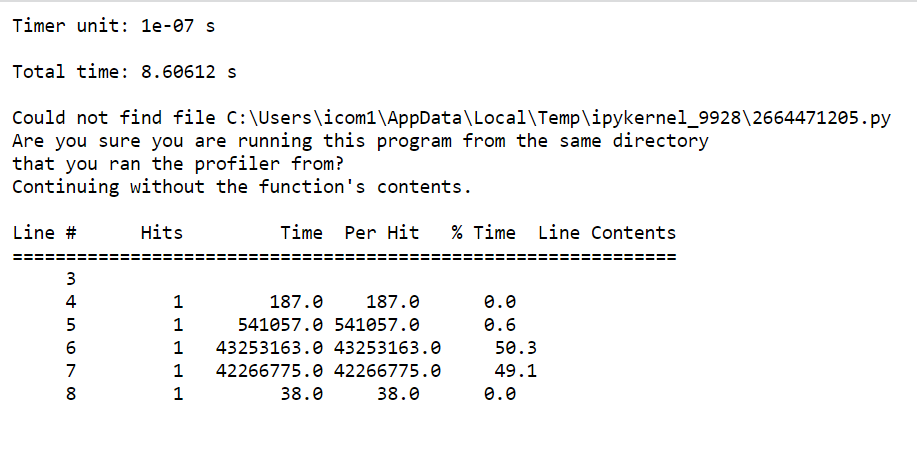

Моя функция выполняется за 8,6 секунд, в то время как исходная функция работала на моем железе практически 250 секунд
---

## Numba

В файле `rating_predictions.json` хранятся данные о рейтингах рецептов и прогнозных значениях рейтингов для этого рецепта, полученных при помощи модели машинного обучения. 

Напишите несколько версий функции (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от прогнозного значения рейтинга для данного рецепта. 


Замечание 1: в формуле MAPE под $A_t$ понимается рейтинг из отзыва $t$, под $F_t$ - прогнозное значения рейтинга отзыва $t$.

Замечание 2: в результате работы функций должно получиться одно число - MAPE для всего набора данных.

In [146]:
import json
with open(
    path+'rating_predictions.json', 
    'r',
     encoding = 'utf-8'
) as fp:
    #Action
    book = json.load(fp)

3\.1 Создайте два списка `A_list` и `F_list` на основе файла `rating_predictions.json`. Напишите функцию `mape_lists` без использования векторизованных операций и методов массивов `numpy` и без использования `numba` (проитерируйтесь по спискам и вычислите суммарное значение MAPE для всех элементов, а потом усредните результат).

Измерьте время выполнения данной функции на входных данных `A_list` и `F_list`. Временем, затрачиваемым на создание списков, можно пренебречь.
    

In [147]:
A_list = []
F_list = []
for line in book:
        A_list.append(line['rating'])
        F_list.append(line['prediction'])
len(A_list), len(F_list)

(119891, 119891)

In [156]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(A_list, F_list)*100

13.32526550399145

In [157]:
def mape_lists(A_list, F_list):
    c = 0
    for i in range(len(A_list)):
        c += abs((A_list[i] - F_list[i])/A_list[i])
    return 100*c/len(A_list)

In [158]:
%time mape_lists(A_list, F_list)

CPU times: total: 31.2 ms
Wall time: 33.5 ms


13.325265503992638

3\.2. Создайте массивы `numpy` `A_array` и `F_array` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numpy` с использованием векторизованных операций и методов массивов `numpy`.

Измерьте время выполнения данной функции на входных данных `A_array` и `F_array`. Временем, затрачиваемым на создание массивов, можно пренебречь.

In [159]:
A_array = np.array(A_list)
F_array = np.array(F_list)

In [172]:
def mape_numpy(A_array, F_array):
    mape = abs((A_array-F_array)/A_array)
    return 100*mape.sum()/len(F_array)

In [173]:
%time mape_numpy(A_array, F_array)

CPU times: total: 0 ns
Wall time: 2.1 ms


13.32526550399145

3\.3. Создайте объекты `numba.typed.List` `A_typed` и `F_typed` на основе списков `A_list` и `F_list`. Напишите функцию `mape_numba` без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`. 

Измерьте время выполнения данной функции на входных данных `A_typed` и `F_typed`. Временем, затрачиваемым на создание объектов `numba.typed.List`, можно пренебречь.

Измерьте время выполнения данной функции на входных данных `A_numpy` и `F_numpy`.

In [195]:
A_typed = numba.typed.List(A_list)
F_typed = numba.typed.List(F_list)

In [198]:
@njit
def mape_numba(A_typed, F_typed):
    c = 0
    for i in range(len(A_typed)):
        c += abs((A_typed[i] - F_typed[i])/A_typed[i])
    return 100*c/len(A_typed)

In [199]:
%time mape_numba(A_typed, F_typed)

CPU times: total: 391 ms
Wall time: 413 ms


13.325265503992638

In [200]:
%time mape_numba(A_typed, F_typed)

CPU times: total: 15.6 ms
Wall time: 3.95 ms


13.325265503992638

In [201]:
%time mape_numba(A_array, F_array)

CPU times: total: 359 ms
Wall time: 365 ms


13.325265503992638

In [202]:
%time mape_numba(A_array, F_array)

CPU times: total: 0 ns
Wall time: 997 µs


13.325265503992638

## Векторизация

Сайт-агрегатор устроил акцию: он дарит купоны на посещение ресторана тем пользователям, оставившим отзывы, идентификатор которых является _красивым числом_. Натуральное число называется _красивым_, если первая цифра числа совпадает с последней цифрой числа. 



4\.1 Напишите функцию `is_pretty`, которая для каждого идентификатора пользователя из файла определяет, получит ли он подарок. Запрещается преобразовывать идентификатор пользователя к строке. Подтвердите корректность реализации, продемонстрировав примеры.

In [203]:
ids = reviews["recipe_id"].values

In [204]:
type(ids[0]), ids[0]

(numpy.int64, 57993)

In [205]:
ids[0]//10

5799

In [206]:
def is_pretty(n: int) -> bool:
    last = n%10
    while n > 9:
        n = n//10
    return last==n

In [207]:
ids[100], is_pretty(ids[100])

(356161, False)

4\.2 Посчитайте с помощью функции `is_pretty` количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.

In [208]:
%%time
counter = 0
for i in ids:
    if is_pretty(i):
        counter += 1
counter

CPU times: total: 281 ms
Wall time: 285 ms


10752

4\.3. При помощи `numpy` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [209]:
is_pretty_vectorize = np.vectorize(is_pretty)

In [210]:
%%timeit
np.count_nonzero(is_pretty_vectorize(ids))

146 ms ± 6.85 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


4\.4. При помощи `numba` создайте векторизованную версию функции `is_pretty`. Посчитайте с помощью этой векторизованной функции количество пользователей, которые получат подарок. Выведите это количество на экран. Измерьте время расчетов для входных данных `ids`.


In [211]:
is_pretty_numba = numba.vectorize()(is_pretty)

In [212]:
%%time
np.count_nonzero(is_pretty_numba(ids))

CPU times: total: 250 ms
Wall time: 286 ms


10752

In [213]:
%%time
np.count_nonzero(is_pretty_numba(ids))

CPU times: total: 0 ns
Wall time: 4.83 ms


10752